In [1]:
import sys
sys.path += ['..']

In [2]:
#import custom_need

In [ ]:
import os 
import pickle
import argparse
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from torch.autograd import Variable

from models.model_wrapper import WrappedModel
from data import datasets
from data.graph_wrapper import GeneManiaGraph, RegNetGraph
from data.utils import record_result

from sklearn.model_selection import train_test_split

import networkx as nx
import seaborn as sns

## Loading custom dataset

In [4]:
# Load data from files
dataset = datasets.DatasetFromCSV(name='TARGET_AML', 
                   expr_path='../datastore/TARGET_RSEM_gene_tpm.txt.gz', 
                   label_path='../datastore/TARGET_phenotype.txt.gz', 
                   label_name='_primary_disease') 

In [5]:
# Define a new task as being greater than the mean
dataset.df = dataset.df - dataset.df.mean(axis=0)
label_df = dataset.df.where(dataset.df > 0).notnull().astype("int")

In [6]:
# Load GeneMania's graph
if os.path.exists('../datastore/gene-mania-graph.hdf5') : 
    G = GeneManiaGraph('../datastore/gene-mania-graph.hdf5')
else : 
    G = GeneManiaGraph()  
    ## NOTE : GeneMania's graph will be downloaded in folder ./datastore/ not in ../datastore/

In [7]:
# There are more entries in the TARGET dataset than in the GeneMania graph (non-coding, small RNA, etc...)
print 'Graph node coverage : %.2f' % (len(set(G.node_names)&set(dataset.df.columns))/(len(G.node_names)*1.0)*100)
print 'Dataset node coverage : %.2f' % (len(set(G.node_names)&set(dataset.df.columns))/(dataset.df.shape[1]*1.0)*100)

Graph node coverage : 91.77
Dataset node coverage : 61.04


## Experiment with a MLP as in the paper

In [8]:
# Train an MLP using first degree neighbors, all genes or random set of genes
def train_test_model(df, labels, gene, G, train_size, test_size, use_first_degree, n=10, cuda=False, random=False):
    seed = 123
    model = WrappedModel(name="MLP", column_names=dataset.df.columns, dropout=False, cuda=cuda)

    results = []    
    for i in range(10):
    
        X_train, X_test, y_train, y_test = train_test_split(df, labels, \
                                                      stratify=labels, \
                                                      train_size=train_size, \
                                                      test_size=test_size)
        if use_first_degree:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            X_train = X_train.loc[:, neighbors].copy()
            X_test = X_test.loc[:, neighbors].copy()
            genes = neighbors
        elif random:
            neighbors = list(G.first_degree(gene)[0])
            neighbors = list(set(neighbors)&set(df.columns)) 
            random_genes = np.random.choice(df.columns, len(neighbors)-1) 
            X_train = X_train.loc[:, random_genes].copy()
            X_test = X_test.loc[:, random_genes].copy()
            genes = random_genes
        else:
            X_train = X_train.copy()
            X_test = X_test.copy()
            genes = []
        
        
       
        try:
            X_train[gene] = 1
            X_test[gene] = 1
            
            #X_train.drop(gene, axis=1, inplace=True)
            #X_test.drop(gene, axis=1, inplace=True)
        except:
            pass

        try:
            model.fit(X_train, y_train)
            x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
            if cuda:
                x_test = x_test.cuda()
            y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
            auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
        
            results.append(auc)
        except Exception as e:
            print e
            
    return results, genes

### Looking at S100A8 gene

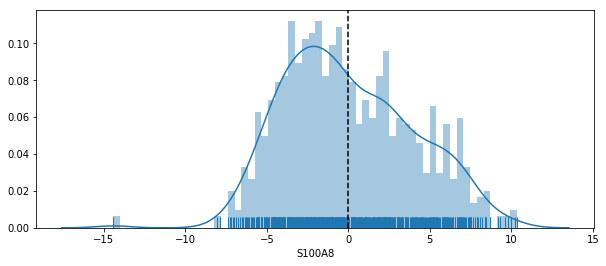

In [9]:
# Train a model for S100A8 gene
gene = "S100A8"
plt.figure(figsize=(10,4))
sns.distplot(dataset.df[gene], rug=True, bins=60)
plt.axvline(x=0, c='black', linestyle='--')
plt.show()

In [10]:
# Train a model for S100A8 gene
print 'Predicting expression above mean for gene : %s' % gene
train_size = 50
test_size = 100
use_first_degree = True
dataset.labels = label_df[gene]

res = pd.DataFrame()
# First degree nodes
results, _ = train_test_model(dataset.df, dataset.labels, gene, G, train_size, test_size, use_first_degree=True)
res.insert(0, 'first', results)
std = np.array(results).std()
mean = np.array(results).mean()
print 'AUC (first degree) : %.3f +/- %.3f' % (mean, std)
         
# All nodes
results, _ = train_test_model(dataset.df, dataset.labels, gene, G, train_size, test_size, use_first_degree=False)
res.insert(0, 'all', results)
std = np.array(results).std()
mean = np.array(results).mean()
print 'AUC (all genes): %.3f +/- %.3f' % (mean, std)

# Random nodes
results, _ = train_test_model(dataset.df, dataset.labels, gene, G, train_size, test_size, use_first_degree=False, random=True)
res.insert(0, 'random', results)
std = np.array(results).std()
mean = np.array(results).mean()
print 'AUC (random): %.3f +/- %.3f' % (mean, std)

Predicting expression above mean for gene : S100A8


/Users/genevieve/Projects/Collaboration/GraphConv-Joseph/venv/lib/python2.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


AUC (first degree) : 0.933 +/- 0.027
AUC (all genes): 0.716 +/- 0.218
AUC (random): 0.891 +/- 0.041


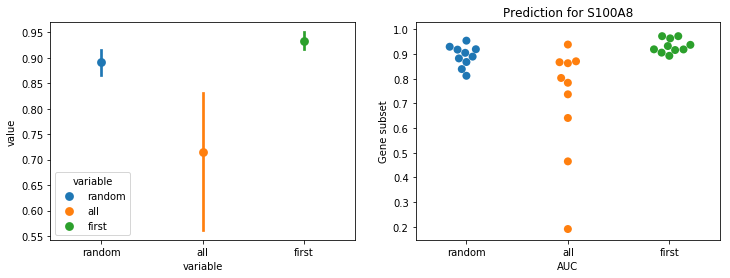

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.pointplot(x='variable', y='value', hue='variable', data=pd.melt(res), size=10, join=False)
plt.subplot(122)
sns.swarmplot(x='variable', y='value', data=pd.melt(res), size=8)
plt.xlabel('AUC')
plt.ylabel('Gene subset')
plt.title('Prediction for %s' % gene)
plt.show()

In [12]:
# Understanding the different steps of the experiment

gene = 'S100A8'
train_size = 50
test_size = 100
use_first_degree = True

X_train, X_test, y_train, y_test = train_test_split(dataset.df, dataset.labels, \
                                                      stratify=dataset.labels, \
                                                      train_size=train_size, \
                                                      test_size=test_size)
        
if use_first_degree:
    gene_graph = G
    neighbors = list(gene_graph.first_degree(gene)[0])
    neighbors = list(set(neighbors)&set(dataset.df.columns)) 
    X_train = X_train.loc[:, neighbors].copy()
    X_test = X_test.loc[:, neighbors].copy()
else:
    X_train = X_train.copy()
    X_test = X_test.copy()


#X_train[gene] = 1
#X_test[gene] = 1
    
X_train.drop(gene, axis=1, inplace=True)
X_test.drop(gene, axis=1, inplace=True)

model = WrappedModel(name="MLP", column_names=dataset.df.columns, dropout=False, cuda=False)
model.fit(X_train, y_train)
x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
            
y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
print auc
            

0.9054545454545454


In [13]:
zip(y_test, np.asarray(y_hat).flatten())[0:5]

[(1, 1.2827624),
 (0, -2.4615097),
 (1, 3.8248901),
 (1, 6.09869),
 (1, -0.09601046)]

## Exploring the data 

In [14]:
# First degree neighbors of S100A8
gene = 'S100A8'
print 'Gene', gene
neighbors = list(gene_graph.first_degree(gene)[0])
print 'Number of first neighbors in graph', len(neighbors)
neighbors = list(set(neighbors)&set(dataset.df.columns))
print 'Number of first neighbors in graph and found in dataset', len(neighbors)

Gene S100A8
Number of first neighbors in graph 58
Number of first neighbors in graph and found in dataset 54


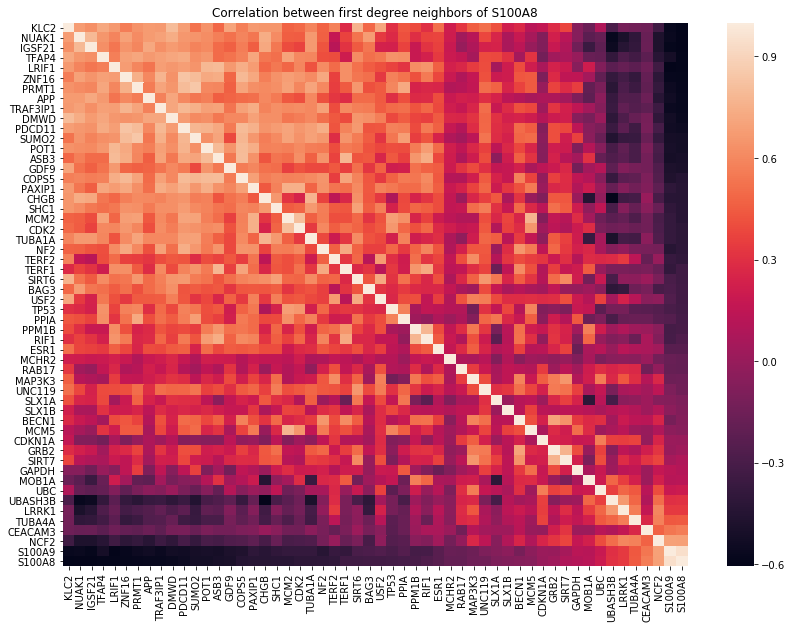

In [15]:
# Computing the correlation between the first degree neighbors of the chosen gene
dat = dataset.df[neighbors]
plt.figure(figsize=(14,10))
tmp = dat.corr().sort_values(gene)
tmp = tmp.loc[:,tmp.index]
ax = sns.heatmap(tmp)
plt.title('Correlation between first degree neighbors of %s' % gene)
plt.show()

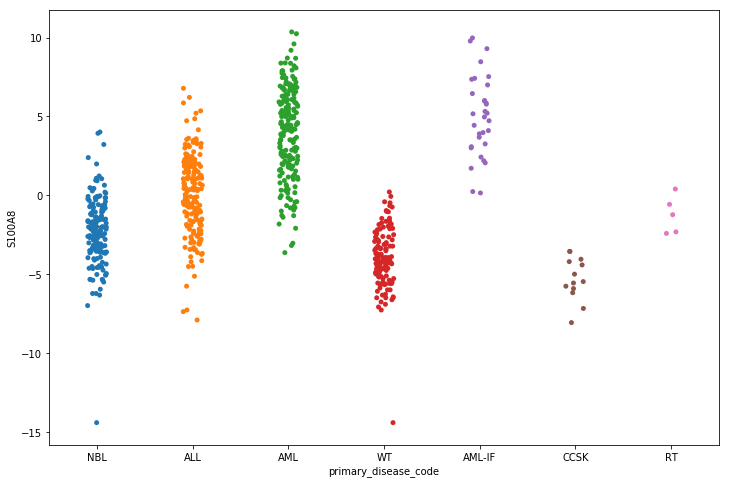

In [16]:
# Exploring the data - clinical characteristics and gene expression
tmp = pd.DataFrame(dataset.df[gene])
tmp.loc[:,'primary_disease_code'] = dataset.lab.loc[list(tmp.index), 'primary_disease_code']
tmp.loc[:,'sample_type_code'] = dataset.lab.loc[list(tmp.index), 'sample_type_code']
tmp.loc[:,'label'] = dataset.labels[list(tmp.index)]
plt.figure(figsize=(12,8))
sns.stripplot(y=gene,x='primary_disease_code', data=tmp)
plt.show()

In [17]:
## Viewing the first degree neighbors

In [18]:
def neighborsOf(graph, nodes, excludes):
    neighbors = set()
    for x in nodes:
        neighbors = neighbors.union(set(graph.neighbors(x)))
    return list(neighbors.difference(set(excludes)))

In [19]:
nx_graph = G.nx_graph
mapping = dict(zip(range(0, len(dataset.df.columns)), dataset.df.columns))
zero_degree = [gene]
first_degree = neighborsOf(nx_graph, zero_degree, zero_degree)

(-0.5494942533502174,
 0.5502534973153663,
 -0.5500982807283108,
 0.5500982807283108)

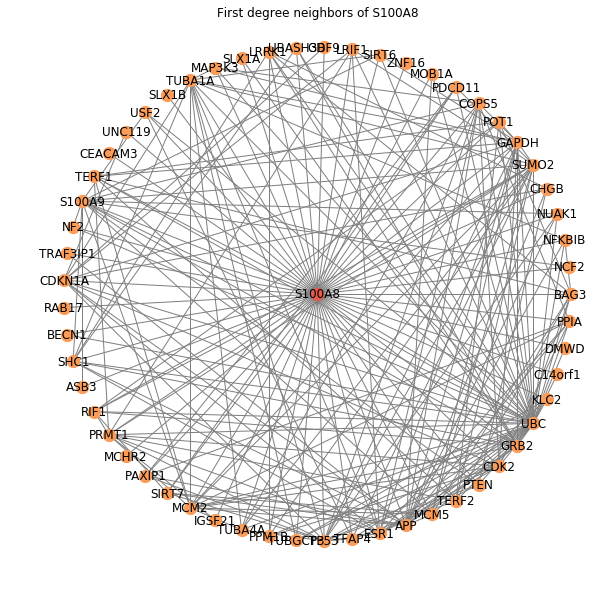

In [20]:
## All first degree neighbors
plt.rcParams['figure.figsize'] = (10, 10)
shells = [zero_degree, first_degree]#, second_degree]#, second_degree, third_degree]
cmap = matplotlib.cm.get_cmap('Spectral')
pos = nx.shell_layout(nx_graph, shells, scale=1)

nod = pos.keys()
edg = [e for e in nx_graph.edges if e[0] in nod and e[1] in nod]
labs = {t:t for t in pos}

nx.draw_networkx_nodes(nx_graph,pos,nodelist=zero_degree, with_labels=True, node_size=150,node_color=cmap(40))
nx.draw_networkx_nodes(nx_graph,pos,nodelist=first_degree, node_size=150,node_color=cmap(70))
nx.draw_networkx_edges(nx_graph, pos, edgelist=edg, edge_color="gray");
nx.draw_networkx_labels(nx_graph, pos, labels=labs, font_size=12);
plt.title('First degree neighbors of %s' % gene)
plt.axis('off')

In [21]:
# Weights from the GeneMania graph
edge_weights = []
for n1, n2 in nx_graph.edges:
    if n2 in first_degree or n1 in first_degree:
        edge_weights.append([n1,n2, nx_graph.get_edge_data(n1, n2)['weight']])
edge_weights = pd.DataFrame(edge_weights)
edge_weights.columns = ['node1', 'node2', 'weight']
ew_min = edge_weights.weight.quantile(0.25) # 25th percentile weight
print ew_min

0.00109999999404


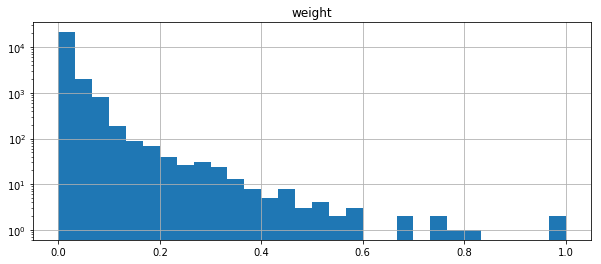

In [22]:
edge_weights.hist(bins=30, figsize=(10,4))
plt.yscale("log", nonposy='clip')
plt.show()

In [23]:
def draw_network(zero_degree, first_degree, nx_graph, df, node_size=2000, edge_to_zero_only=False):
    
    gene = zero_degree[0]
    ## All first degree neighbors
    plt.rcParams['figure.figsize'] = (10, 10)
    shells = [zero_degree, first_degree]
    cmap = matplotlib.cm.get_cmap('Spectral')
    pos = nx.shell_layout(nx_graph, shells, scale=100)

    
    cor_matrix = df.loc[:,pos.keys()].corr()
    cor_matrix.fillna(0, inplace=True)
    
    nod = pos.keys()
    edg = [e for e in nx_graph.edges if e[0] in nod and e[1] in nod]
    if edge_to_zero_only:
        edg = [e for e in edg if e[0]==gene or e[1]==gene]
    labs = {t:t for t in pos}

    nx.draw_networkx_nodes(nx_graph, pos, nodelist=zero_degree, with_labels=True, 
                       node_size=node_size,node_color=cmap(60))


    ndcolor = []
    ndsize = []
    for n in first_degree:
        cor_value = cor_matrix.loc[n, gene]
        cor_direction = np.sign(cor_value)
    
        ndsize.append(node_size*np.abs(cor_value))
    
        if cor_direction == 1:
            ndcolor.append(cmap(60))
        
        elif cor_direction == -1:
            ndcolor.append(cmap(300))
        else :
            ndcolor.append(cmap(1))
     
    
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=first_degree, 
                       node_size=ndsize,
                       node_color=ndcolor )

    
    weights = []
    for n1, n2 in edg:
        weights.append(nx_graph.get_edge_data(n1,n2)['weight']*20)
    
    if len(edg)>0 : 
        nx.draw_networkx_edges(nx_graph, pos, edgelist=edg, 
                      width=weights, edge_color='grey',#edge_color = weights,
                      edge_vmin = min(weights), edge_vmax=max(weights)
                      );
    nx.draw_networkx_labels(nx_graph, pos, labels=labs, font_size=12);

    plt.title('First degree neighbors of %s' % gene)
    #plt.legend([]) 
    plt.axis('off')
    

/Users/genevieve/Local/miniconda2/envs/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


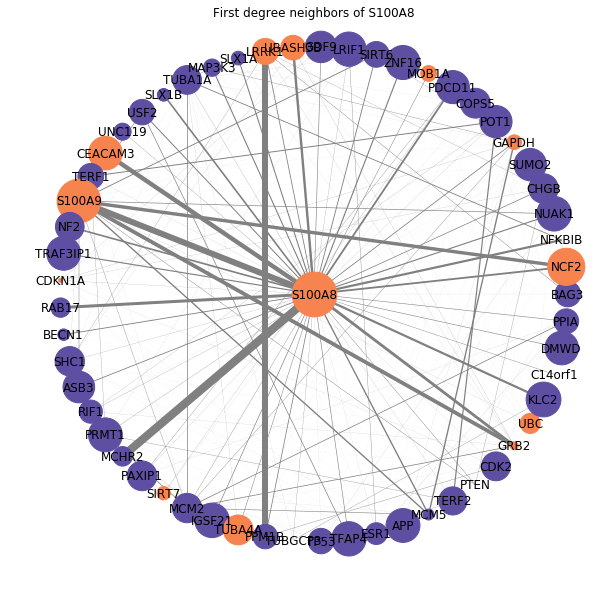

In [24]:
# Representation for the first degree neighbors graph
draw_network([gene], first_degree, nx_graph, dataset.df, node_size=2000)

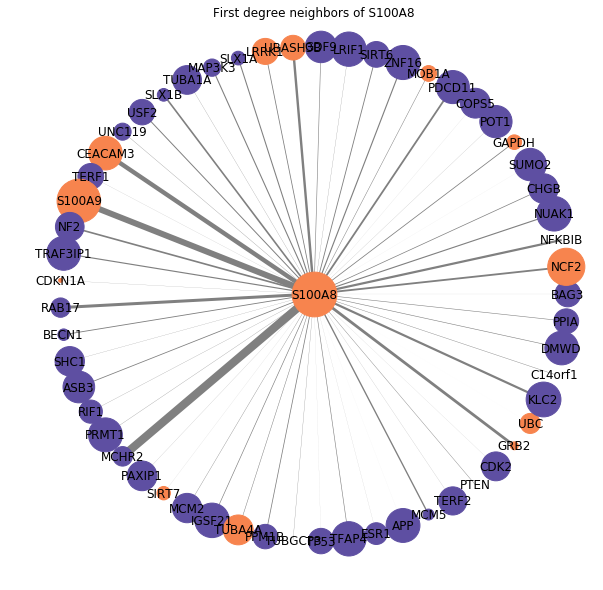

In [25]:
# Representation for the first degree neighbors graph
draw_network([gene], first_degree, nx_graph, dataset.df, node_size=2000, edge_to_zero_only=True)

AUC (random): 0.881 +/- 0.027


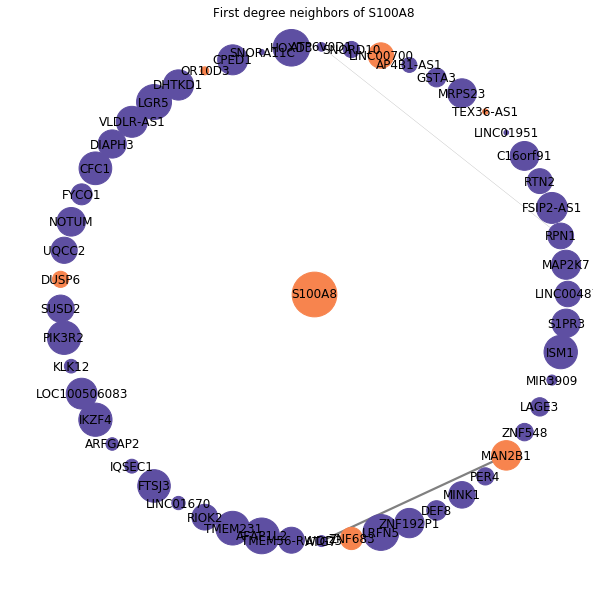

In [26]:
# Representation for a random graph
results, rnodes = train_test_model(dataset.df, dataset.labels, gene, G, train_size, test_size, use_first_degree=False, random=True)
std = np.array(results).std()
mean = np.array(results).mean()
print 'AUC (random): %.3f +/- %.3f' % (mean, std)

draw_network([gene], list(rnodes), nx_graph, dataset.df, node_size=2000)